In [1]:
from pathlib import Path

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm


import librosa
import librosa.display

import soundfile

from pydub import AudioSegment
from pydub.playback import play
from pydub.silence import split_on_silence

In [2]:
test_cough = r"..\\Coswara-Data\Test_data\cough-shallow2.wav" 
test_cough2 = r"..\\Coswara-Data\Test_data\cough-shallow1.wav" 
test_cough3 = r"..\\Coswara-Data\Test_data\cough-shallow.wav" 

In [34]:
y, sr = librosa.load(test_cough, sr=22050)
len(y)

158055

In [35]:


y_new = np.reshape(y, newshape=(-1, 1))
y_new.shape

(158055, 1)

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

y_new = scaler.fit_transform(y_new)
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [43]:
y_new.shape
y_new2 = np.reshape(y_new, (len(y_new)))
y_new2.shape
                    

(158055,)

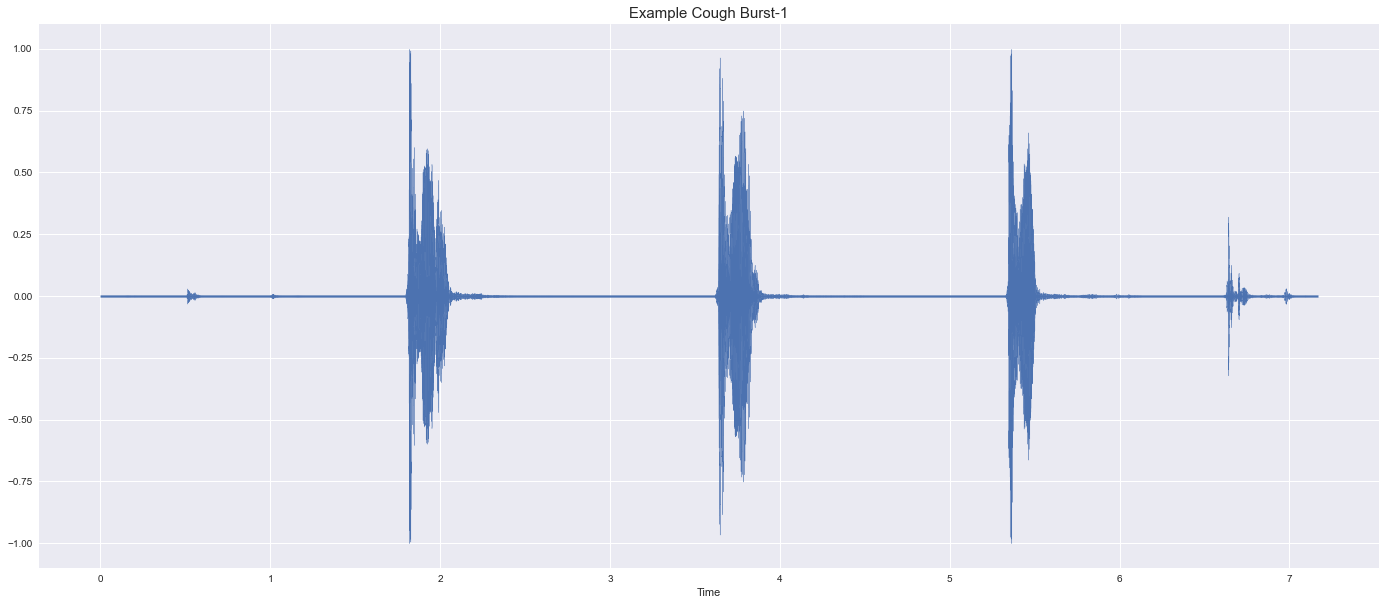

In [44]:
fig, axs = plt.subplots(figsize=(24,10))

img = librosa.display.waveshow(y=y_new2, sr=sr, x_axis='time', ax=axs)
plt.title("Example Cough Burst-1", fontsize=15)
plt.show()

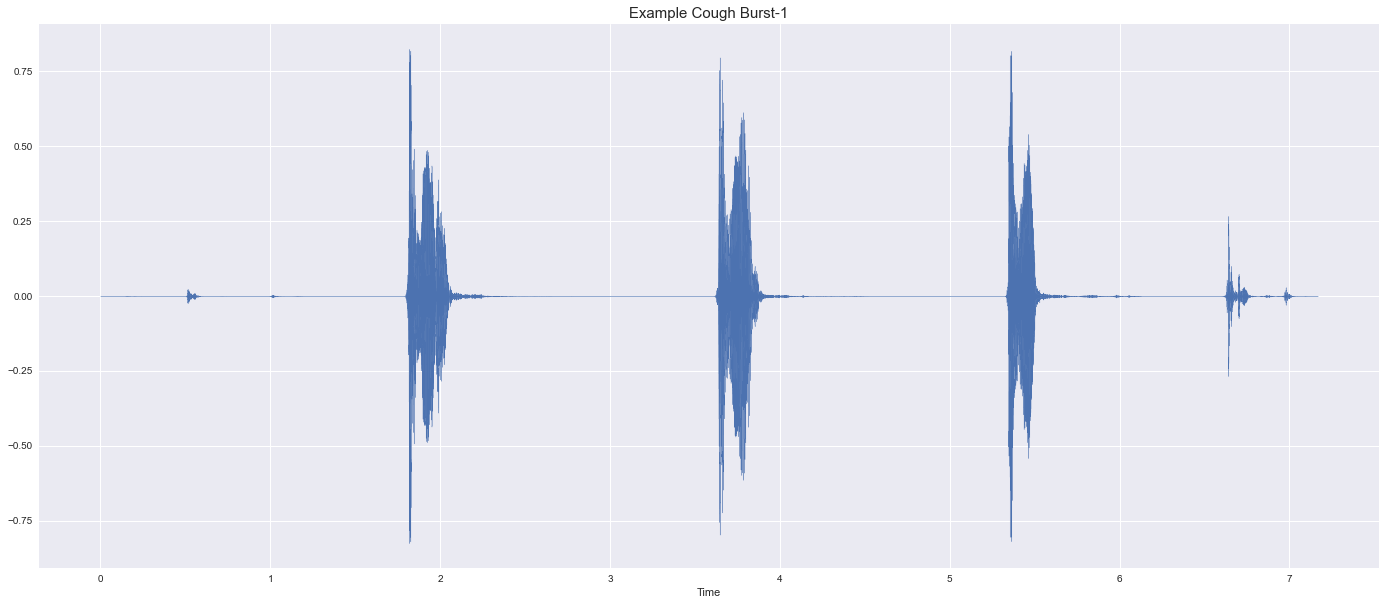

In [41]:
fig, axs = plt.subplots(figsize=(24,10))
img = librosa.display.waveshow(y=y, sr=sr, x_axis='time', ax=axs)
plt.title("Example Cough Burst-1", fontsize=15)
plt.show()

In [9]:
print(y[150000:150050])

[-5.51870698e-07  8.27674569e-07 -1.16086665e-06  1.56676640e-06
 -2.07033304e-06  2.73200499e-06 -3.70728958e-06  5.56476289e-06
 -1.35609653e-05 -1.88925678e-05 -4.89258525e-07 -2.80145923e-05
 -8.43602538e-05 -1.42519362e-04 -1.85063414e-04 -2.76228617e-04
 -3.53774521e-04 -3.52807896e-04 -3.13836470e-04 -3.03885201e-04
 -2.83917005e-04 -2.69777345e-04 -3.21689149e-04 -3.67858011e-04
 -3.04647954e-04 -2.09798221e-04 -1.78519695e-04 -1.88956314e-04
 -1.17887525e-04 -4.92720301e-06  5.43735259e-05  5.40108340e-05
  2.67262167e-05  3.26327136e-05  2.91946308e-05  3.14667523e-05
  2.97558654e-05  3.14329009e-05  2.92230397e-05  7.44612553e-05
  1.30568311e-04  1.49930973e-04  1.55213682e-04  1.49772066e-04
  1.56802795e-04  1.35368507e-04  1.19875760e-04  1.36627932e-04
  1.22156183e-04  1.04814302e-04]


In [3]:
cough1 = AudioSegment.from_wav(test_cough)
play(cough1)

In [ ]:
cough2 = AudioSegment.from_wav(test_cough2)
play(cough2)

In [ ]:
cough3 = AudioSegment.from_wav(test_cough3)
play(cough3)

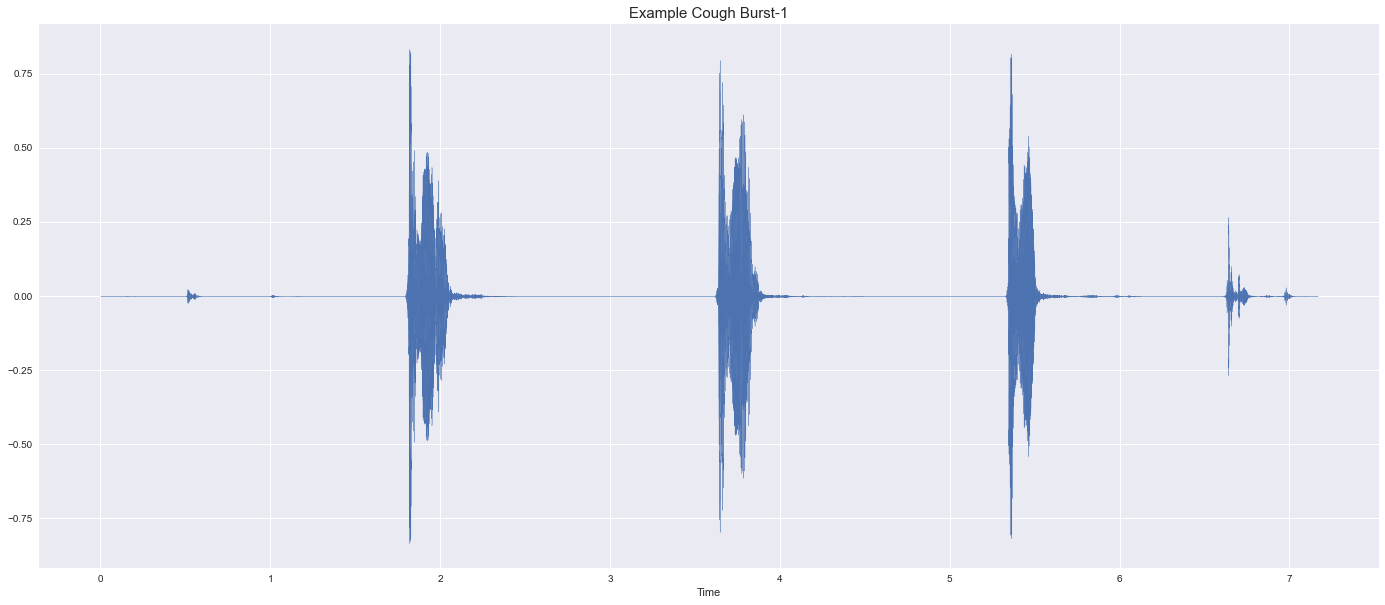

In [4]:
y, sr = librosa.load(test_cough, sr=44100)
y2, sr2 = librosa.load(test_cough2, sr=44100)
y3, sr3 = librosa.load(test_cough3, sr=44100)

fig, axs = plt.subplots(figsize=(24,10))

img = librosa.display.waveshow(y=y, sr=sr, x_axis='time', ax=axs)
plt.title("Example Cough Burst-1", fontsize=15)
plt.show()

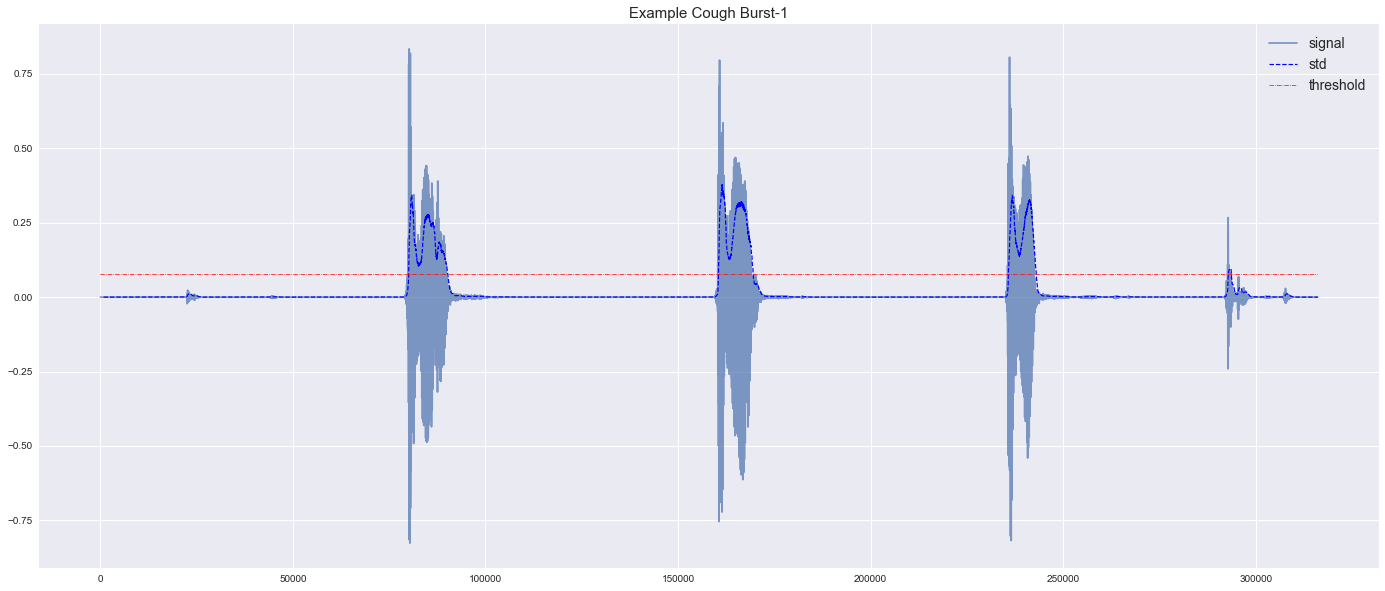

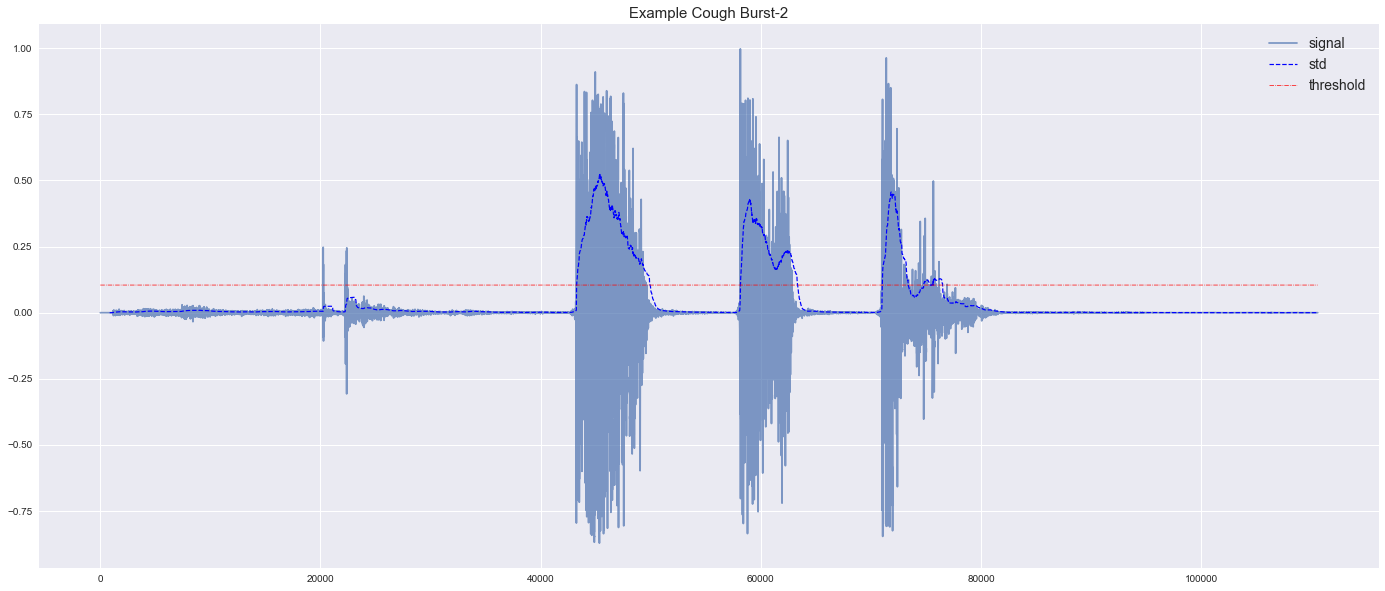

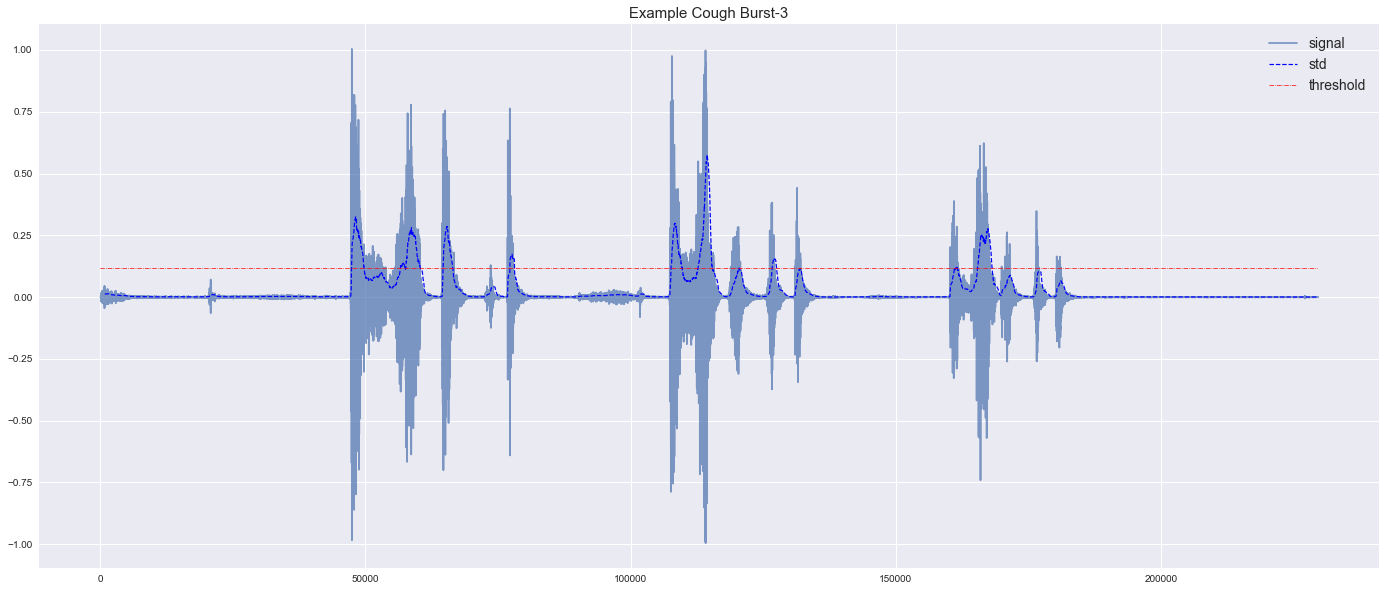

In [5]:
############# INDIVIDUAL TESTING #############

threshold_str = 0.2
roll_std = 850

def plot_signal(y, threshold_str = 0.2, roll_std = 850, title = "Example Cough Burst-1"):
    
    ax = plt.gca()

    df = pd.DataFrame(y, columns = ["signal"])
    df["std"] = df.rolling(roll_std).std()
    threshold = np.max(df["std"]) * threshold_str
    df["threshold"] = threshold 

    df.plot(y = ["signal"], figsize=(24,10), alpha = 0.7, ax=ax)
    df.plot(y = ["std"], figsize=(24,10), ax=ax, style="--", alpha = 1.0, color="b", linewidth=1.2)  
    df.plot(y = ["threshold"], figsize=(24,10), ax=ax, style="-.", linewidth=0.7, color = "r")  
    plt.legend(fontsize=14)
    plt.title(title, fontsize=15)
    plt.show()
    
    return(df)
    
df1 = plot_signal(y, title = "Example Cough Burst-1")
df2 = plot_signal(y2, title = "Example Cough Burst-2")
df3 = plot_signal(y3, title = "Example Cough Burst-3")

In [9]:


# Extracting individual cough start and end time
def start_end(df, threshold = threshold_str, save_trim = False):
        
    starts = []
    ends = []

    for idx, _ in tqdm(df.iterrows(), total = df.shape[0]):
        
        std = df["std"][idx]
        
        if df["std"][idx] == None:
            continue

        if idx < (len(df) - 1):
            if df["std"][idx] < threshold and df["std"][idx+1] >= threshold:
                starts.append(idx)
                continue
            
            if df["std"][idx] >= threshold and df["std"][idx+1] < threshold:
                ends.append(idx)
                continue
        else:
            break
    
    if save_trim:
        
        # Slicing and saving the trims
        i = 0
        for start, end in zip(starts, ends):
                
            # slicing signal
            y_new = np.array(df.loc[start:end, "signal"])
            file_name = "file_trim_%i.wav" % (i)
            soundfile.write(file_name, y_new, samplerate = sr)
            i += 1        
        
    # Start and end time of the cough signals
    df["start"] = None
    df["end"] = None

    for i in starts:
        
        signal  = df["signal"][i]
        df.loc[i, "start"] = signal

    for t in ends:
        
        signal2  = df["signal"][t]
        df.loc[t, "end"] = signal2
        
    return(df)    



100%|█████████▉| 229555/229556 [00:42<00:00, 5404.29it/s]


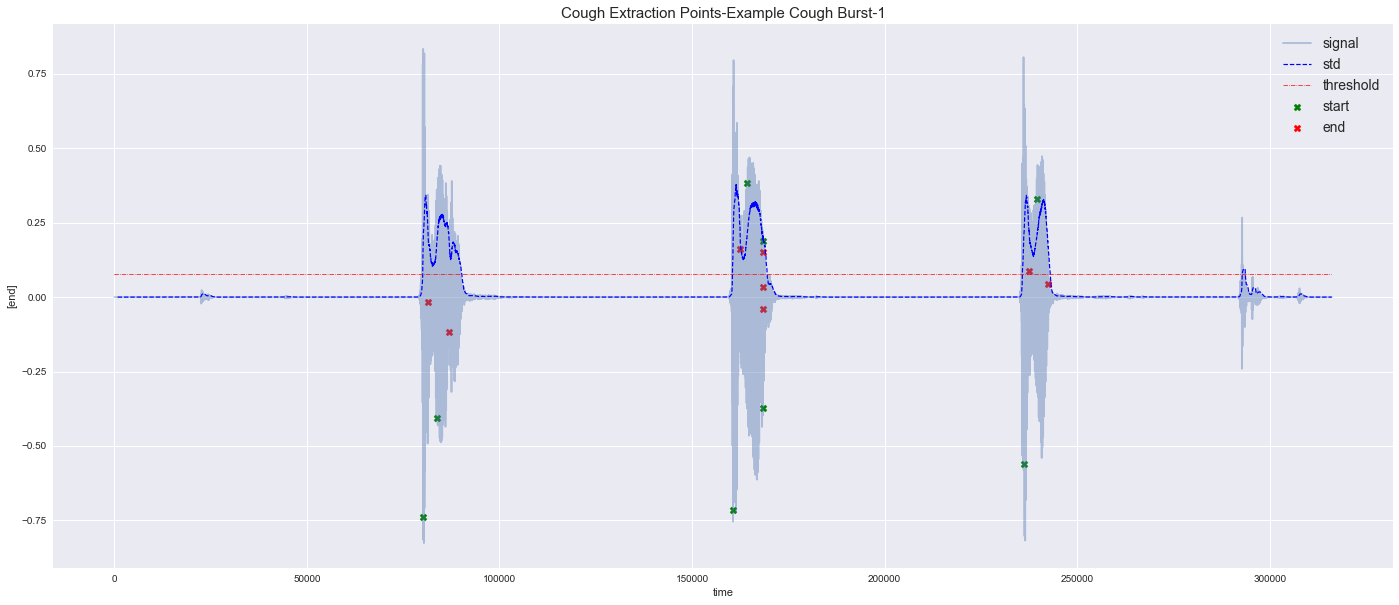

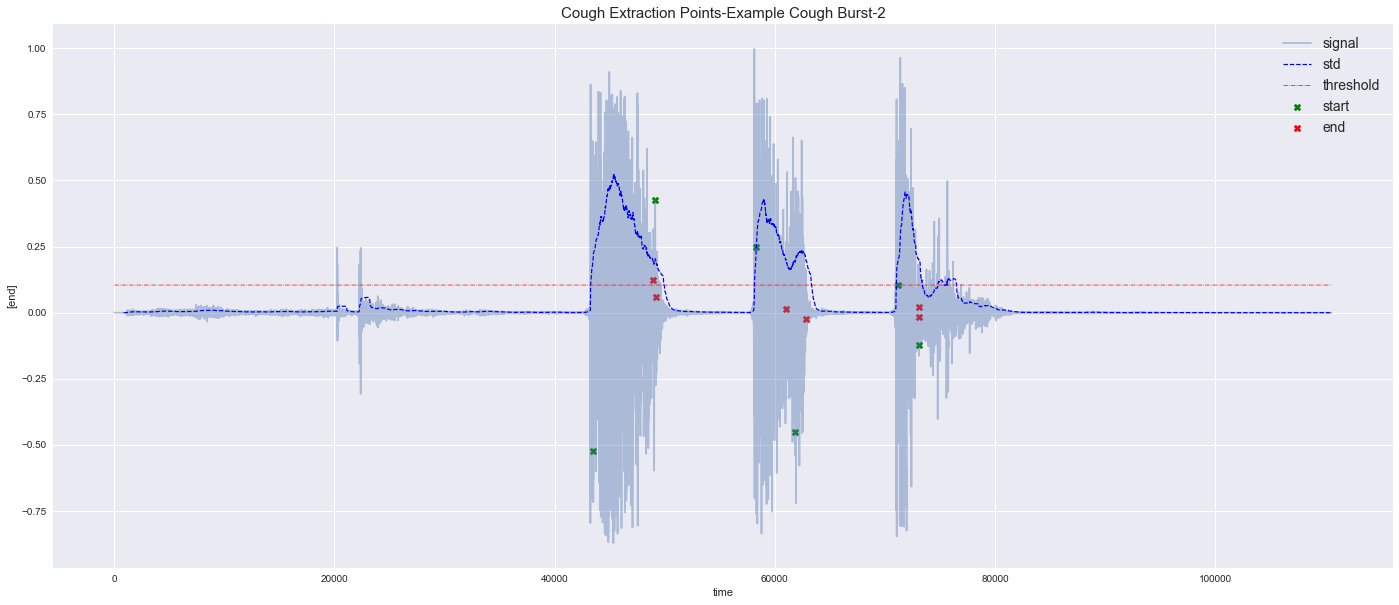

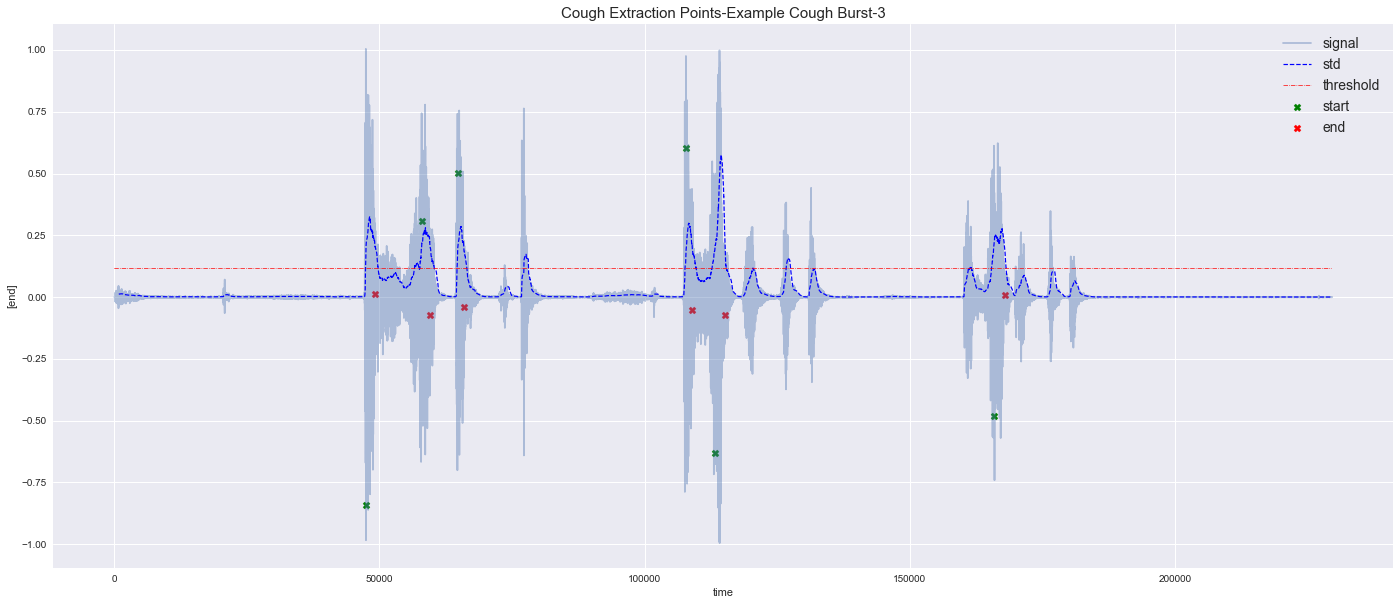

In [11]:
df1 = start_end(df1)
df2 = start_end(df2)
df3 = start_end(df3)


def plot_extraction(df, title = None):
    
    df["time"] = df.index
    ax = plt.gca()

    df.plot(y = ["signal"], figsize=(24,10), alpha = 0.4, ax=ax)
    df.plot(y = ["std"], figsize=(24,10), ax=ax, style="--", alpha = 1.0, color="b", linewidth=1.2)  
    df.plot(y = ["threshold"], figsize=(24,10), ax=ax, style="-.", linewidth=0.7, color = "r")  

    df.plot.scatter(x = "time", y = ["start"], figsize=(24,10), ax=ax, marker = 'X', color = 'green', s = 50, legend=True)
    df.plot.scatter(x = "time", y = ["end"], figsize=(24,10), ax=ax, marker = 'X', color = '#ff0000', s = 50, legend=True)

    plt.legend(["signal", "std", "threshold", "start", "end"], loc = 'best', fontsize=14)
    plt.title(title, fontsize=15)
    plt.show()

plot_extraction(df1, title = "Cough Extraction Points-Example Cough Burst-1")
plot_extraction(df2, title = "Cough Extraction Points-Example Cough Burst-2")
plot_extraction(df3, title = "Cough Extraction Points-Example Cough Burst-3")

